# Who said it?

In [1]:
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
import tensorflow as tf
import pandas as pd
import json
import gc

In [2]:
df = pd.read_csv("the-office-lines_scripts.csv")

# list of 5 most common speakers
speakers = df['speaker'].value_counts().head(5).index.tolist()

# filter dataframe to only include the 5 most common speakers
df = df[df['speaker'].isin(speakers)]
df['encoded_speaker'] = df['speaker'].astype('category').cat.codes

# only keep the speaker and line columns
df = df[['speaker', 'line_text', 'encoded_speaker']]

data_text = df['line_text'].to_list()
data_labels = df['encoded_speaker'].to_list()

In [3]:
from sklearn.utils import class_weight
import numpy as np

# create class weight dictionary
class_weight_dict = class_weight.compute_class_weight('balanced', classes=np.unique(data_labels), y=data_labels)
class_weight_dict = dict(enumerate(class_weight_dict))

In [4]:
# list of unique speakers with their encodings
dict(zip(df['speaker'], df['encoded_speaker']))

{'Michael': 3, 'Jim': 2, 'Pam': 4, 'Dwight': 1, 'Andy': 0}

In [5]:
df.head()

,speaker,line_text,encoded_speaker
0,Michael,All right Jim. Your quarterlies look very good...,3
1,Jim,"Oh, I told you. I couldn't close it. So...",2
2,Michael,So you've come to the master for guidance? Is ...,3
3,Jim,"Actually, you called me in here, but yeah.",2
4,Michael,"All right. Well, let me show you how it's done.",3


In [6]:
from sklearn.model_selection import train_test_split

# Split Train and Validation data
train_texts, val_texts, train_labels, val_labels = train_test_split(data_text, data_labels, test_size=0.2, random_state=0)

# Keep some data for inference (testing)
train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size=0.01, random_state=0)

In [7]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

2023-03-14 20:22:45.266459: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9657 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1c:00.0, compute capability: 7.5
2023-03-14 20:22:45.269012: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9666 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1d:00.0, compute capability: 7.5
2023-03-14 20:22:45.271342: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 9666 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1e:00.0, compute capability: 7.5
2023-03-14 20:22:45.273883: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 9666 MB memory:  -> device: 3, name: NVIDIA GeForce RTX

In [9]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])

2023-03-13 19:58:46.121099: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_projector', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint 

In [10]:
model.fit(train_dataset.shuffle(1000).batch(16), epochs=5, batch_size=16,
          validation_data=val_dataset.shuffle(1000).batch(16), class_weight=class_weight_dict)

2023-03-13 19:58:47.652414: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


/usr/local/lib/python3.8/dist-packages/tensorflow/python/autograph/impl/api.py:376: FutureWarning: The old compute_loss method is deprecated as it conflicts with the Keras compute_loss method added in TF 2.8. If you want the original HF compute_loss, please call hf_compute_loss() instead. From TF versions >= 2.8, or Transformers versions >= 5, calling compute_loss() will get the Keras method instead.
  return py_builtins.overload_of(f)(*args)


1774/1774 [==============================] - 611s 339ms/step - loss: 1.5247 - accuracy: 0.3052 - val_loss: 1.4963 - val_accuracy: 0.3345
Epoch 2/5
1774/1774 [==============================] - 602s 339ms/step - loss: 1.3315 - accuracy: 0.4332 - val_loss: 1.4760 - val_accuracy: 0.3601
Epoch 3/5
1774/1774 [==============================] - 602s 339ms/step - loss: 1.0491 - accuracy: 0.5621 - val_loss: 1.5595 - val_accuracy: 0.3909
Epoch 4/5
1774/1774 [==============================] - 601s 339ms/step - loss: 0.7798 - accuracy: 0.6746 - val_loss: 1.7388 - val_accuracy: 0.3929
Epoch 5/5
1774/1774 [==============================] - 602s 339ms/step - loss: 0.6096 - accuracy: 0.7406 - val_loss: 2.1801 - val_accuracy: 0.3953


In [9]:
save_directory = "/classifier" # change this to your preferred location

In [12]:
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)


('/classifier/tokenizer_config.json',
 '/classifier/special_tokens_map.json',
 '/classifier/vocab.txt',
 '/classifier/added_tokens.json')

In [10]:
loaded_tokenizer = DistilBertTokenizer.from_pretrained(save_directory)
loaded_model = TFDistilBertForSequenceClassification.from_pretrained(save_directory)

2023-03-14 20:23:20.061554: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at /classifier.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [11]:
test_text = "Hi i'm Michael Scott, and I'm the regional manager."


predict_input = loaded_tokenizer.encode(test_text,
                                 truncation=True,
                                 padding=True,
                                 return_tensors="tf")

output = loaded_model(predict_input)[0]

prediction_value = tf.nn.softmax(output, axis=1).numpy()[0]

# apply softmax to prediction values

print(
    "Andy: {:.2f}%\tDwight: {:.2f}%\tJim: {:.2f}%\tMichael: {:.2f}%\tPam: {:.2f}%".format(
        100 * prediction_value[0],
        100 * prediction_value[1],
        100 * prediction_value[2],
        100 * prediction_value[3],
        100 * prediction_value[4]
    )
)

Andy: 77.11%	Dwight: 0.27%	Jim: 0.38%	Michael: 22.23%	Pam: 0.02%


Best examples:
"And this is how to stab someone in the back."
"That's what she said."

In [15]:
from tqdm import tqdm

In [16]:
# create a confusion matrix evaluating the above class predictions
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# get predictions for validation data
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

print("Validation dataset size: {}".format(len(val_dataset)))

val_predictions = []

for batch in tqdm(val_dataset):
    val_predictions.append(loaded_model(batch[0])[0])

val_predictions = tf.concat(val_predictions, axis=0)
val_predictions = tf.nn.softmax(val_predictions, axis=1).numpy()

# get the predicted class
val_predictions = val_predictions.argmax(axis=1)



Validation dataset size: 7165


100%|████████████████████████████████████████████████████████████████████████████| 7165/7165 [06:14<00:00, 19.15it/s]


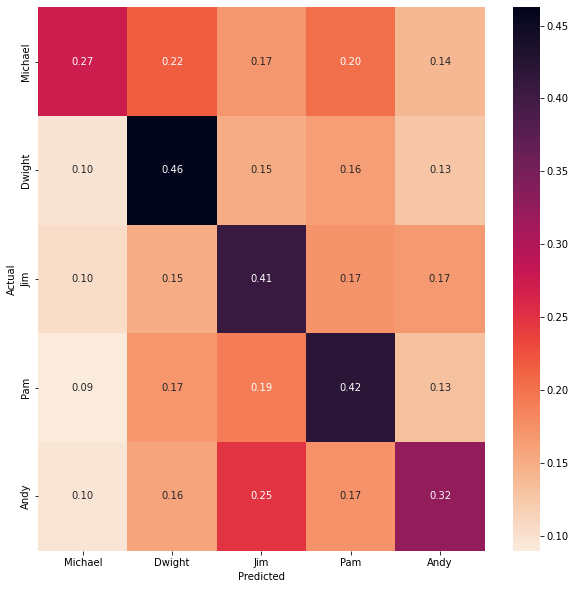

In [17]:
# create a confusion matrix evaluating the above class predictions (normalized)
cm = confusion_matrix(val_labels, val_predictions, normalize='true')

# plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, cmap='rocket_r', annot=True, fmt='.2f', xticklabels=speakers, yticklabels=speakers)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
for l in df['line_text'][:200]:
    predict_input = loaded_tokenizer.encode(test_text,
                                    truncation=True,
                                    padding=True,
                                    return_tensors="tf")
    
    output = loaded_model(predict_input)[0]
    prediction_value = tf.nn.softmax(output, axis=1).numpy()[0]

    output = loaded_model(predict_input)[0]

In [13]:
# save the model as file
loaded_model.save_pretrained("classifier")

In [31]:

def predict_value(to_predict):

    # prediction_probas = []
    # for elem in to_predict:
    #     predict_input = loaded_tokenizer.encode(elem,
    #                                     truncation=True,
    #                                     padding=True,
    #                                     return_tensors="tf")
    #     output = loaded_model(predict_input)[0]
    #     prediction_probas +=[np.array(tf.nn.softmax(output, axis=1)[0])]

    # prediction_probas = np.array(prediction_probas)

    # without for loop only predict one proba
    predict_input = loaded_tokenizer.encode(to_predict,
                                    truncation=True,
                                    padding=True,
                                    return_tensors="tf")
    output = loaded_model(predict_input)[0]

    pred = tf.nn.softmax(output, axis=1)[0]

    format_pred = np.concatenate([1.0-pred, pred], axis=0)

    return format_pred


In [22]:
print("Question: \n", val_texts[0])
print("Probability: \n", predict_value(val_texts[0])[0,1])
print("Probability (4)): \n", predict_value(val_texts[0])[0,3])
print("True label: \n", val_labels[0])

Question: 
 Oh my God. Is that Jan? [points to same monitor]
Probability: 
 0.008339685
Probability (4)): 
 0.9738261
True label: 
 4


In [35]:
# use SHAP to explain the model
import shap

# create a background dataset to integrate over
background = train_dataset.shuffle(100).batch(1)

# explain predictions on our validation dataset
e = shap.GradientExplainer(loaded_model, background)
shap_values = e.shap_values(val_dataset.batch(1))

# plot the feature attributions
shap.plots.text(shap_values[0])


TypeError: 'BatchDataset' object is not subscriptable

In [24]:
# # use lime to explain the tf model above
# from lime.lime_text import LimeTextExplainer

# cn = list(set(data_labels))

# explainer = LimeTextExplainer(class_names=cn)
# explainer.explain_instance(val_texts[0], 
#                            classifier_fn = predict_value, num_features=1)

ValueError: Found input variables with inconsistent numbers of samples: [5000, 1]

In [ ]:
shaplei
lime
